In [1]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler
import os
import splitfolders
import random
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU
import keras
import segmentation_models_3D as sm
import pandas as pd
import time
import tensorflow.keras.backend as K

Segmentation Models: using `tf.keras` framework.


In [2]:
# import tensorflow as tf
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

625.0
[0 1 2 4]
[0 1 2 3]


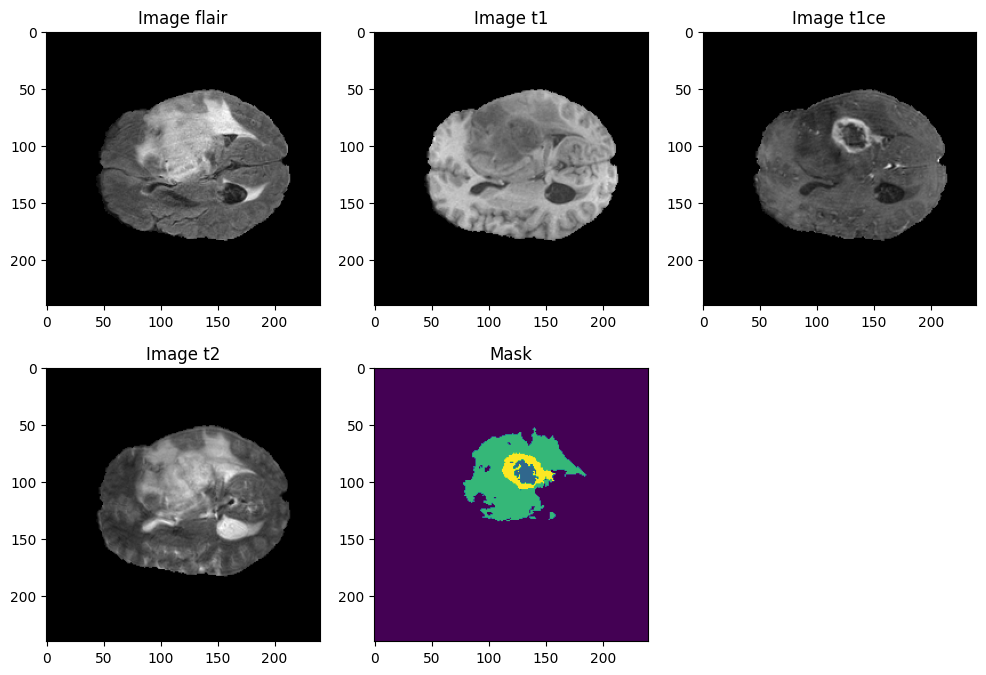

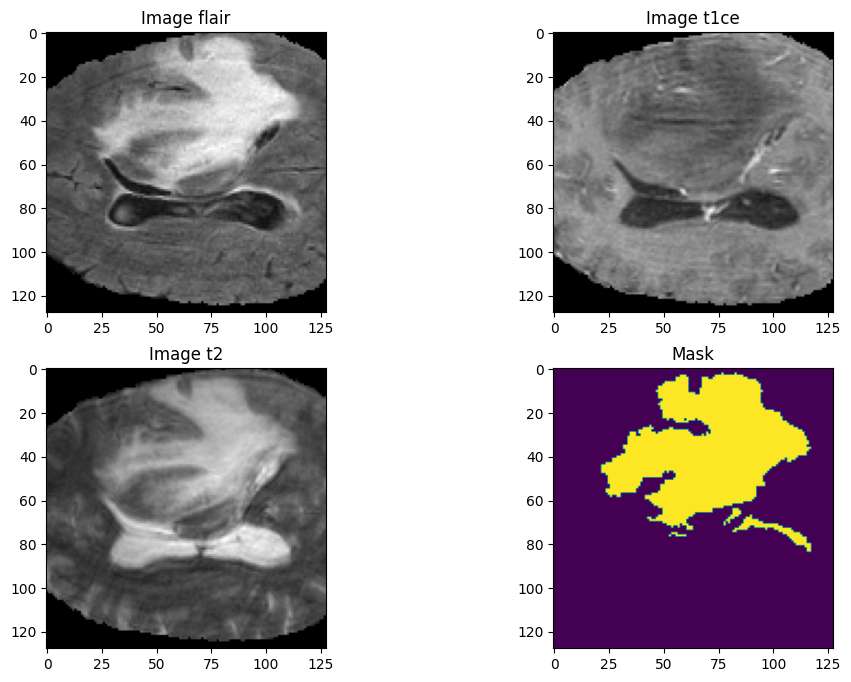

In [9]:
scaler = MinMaxScaler()

TRAIN_DATASET_PATH = "brats_2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/"
# TRAIN_DATASET_PATH = 'archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
#VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001_flair.nii').get_fdata()
# print(test_image_flair)
print(test_image_flair.max())
#Scalers are applied to 1D so let us reshape and then reshape back to original shape. 
test_image_flair_scaled=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001_seg.nii').get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask)) 

import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


##################################################
#PART 2: Explore the process of combining images to channels and divide them to patches
#Includes...
#Combining all 4 images to 4 channels of a numpy array.
#
################################################
#Flair, T1CE, annd T2 have the most information
#Combine t1ce, t2, and flair into single multichannel image

combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

#Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
#cropping x, y, and z
#combined_x=combined_x[24:216, 24:216, 13:141]

combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4

#Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]

# n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


In [4]:
scaler = MinMaxScaler()

#t1_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1.nii'))
t2_list = sorted(glob.glob('brats_2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list = sorted(glob.glob('brats_2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob.glob('brats_2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list = sorted(glob.glob('brats_2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))

#Each volume generates 18 64x64x64x4 sub-volumes. 
#Total 369 volumes = 6642 sub volumes
count=0
for img in range(len(t2_list)):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    #print(np.unique(temp_mask))
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save('BraTS2020_TrainingData/input_data_3channels/images/image_'+str(img)+'.npy', temp_combined_images)
        np.save('BraTS2020_TrainingData/input_data_3channels/masks/mask_'+str(img)+'.npy', temp_mask)
        count+=1
    else:
        print("I am useless")
    clear_output(wait=True)

  
print(count)


input_folder = 'BraTS2020_TrainingData/input_data_3channels/'
output_folder = 'BraTS2020_TrainingData/input_data_128/'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.70, .20, .10), group_prefix=None) # default values

344


In [3]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)


def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [3]:
kernel_initializer =  'he_uniform' #Try others if you want
# kernel_initializer = 'TruncatedNormal'
################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible.
    model.summary()
    tf.keras.utils.plot_model(model, show_shapes=True)
    img_file = './model_arch.png'

    tf.keras.utils.plot_model(model, to_file=img_file, show_shapes=True, show_layer_names=True)
    return model

#Test if everything is working ok.
model = simple_unet_model(128, 128, 128, 3, 4)
# print(model.input_shape)
# print(model.output_shape)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

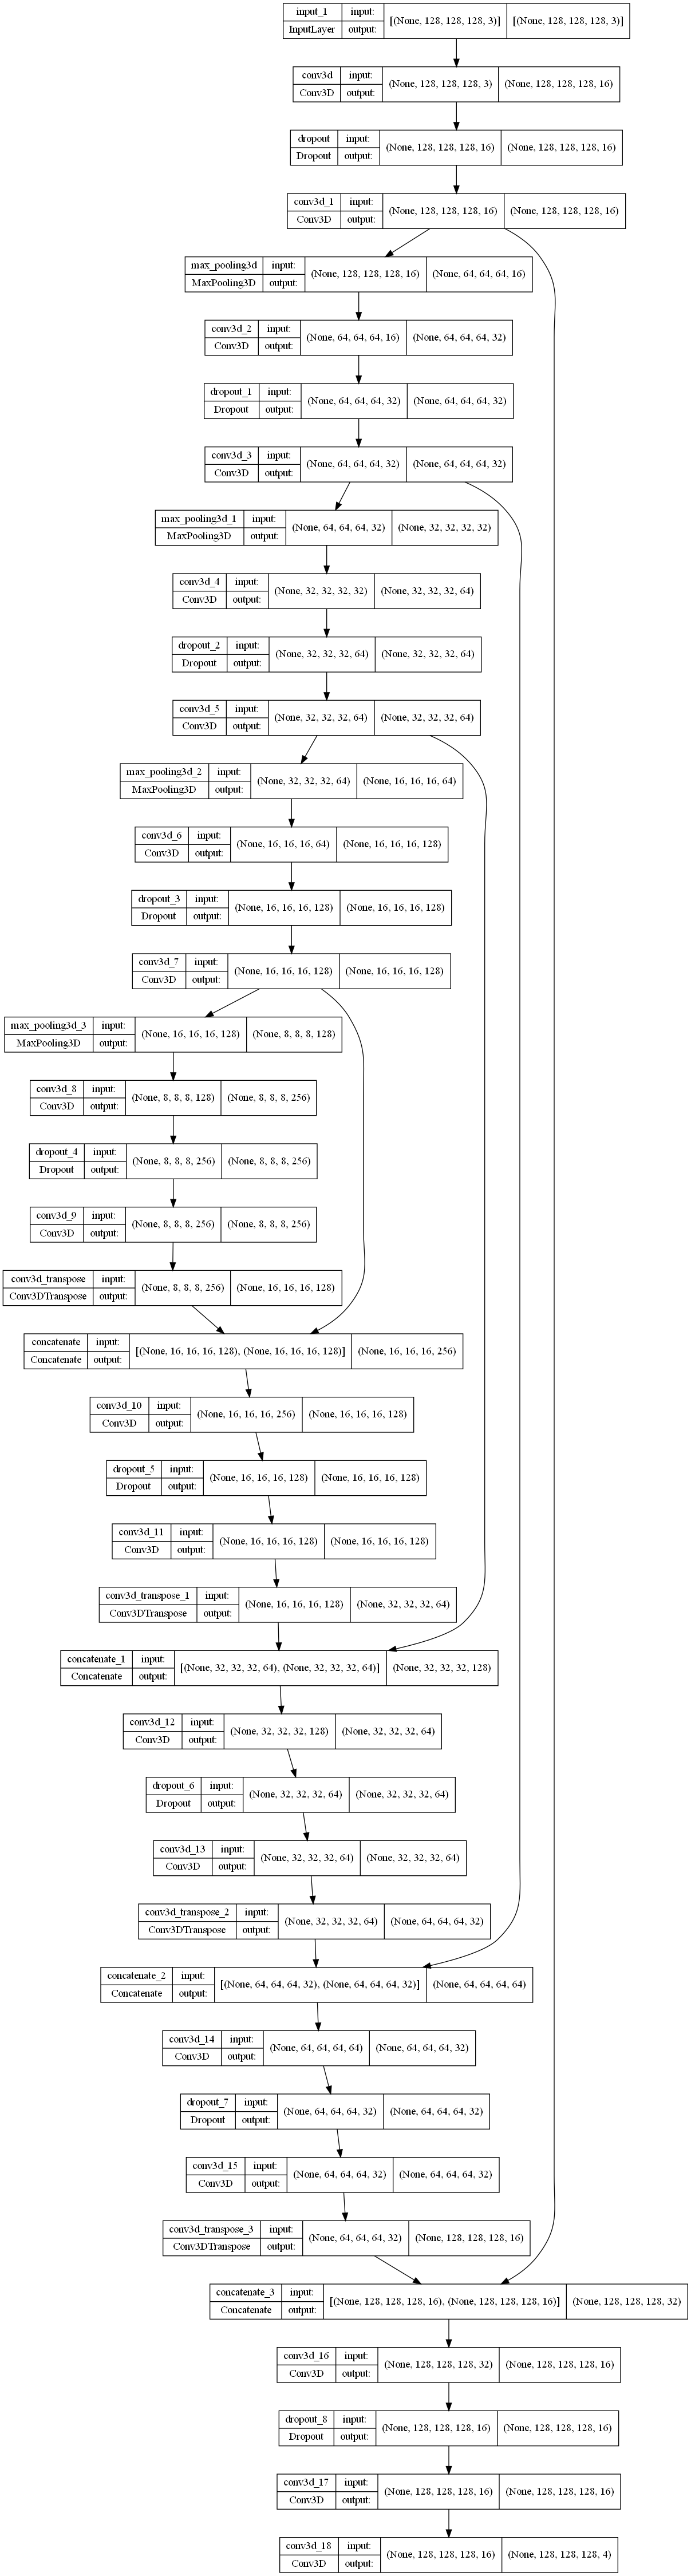

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model

from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from IPython.core.display import Image
keras.utils.plot_model(model, show_shapes=True)

In [5]:
train_img_dir = "BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "BraTS2020_TrainingData/input_data_128/train/masks/"

val_img_dir = "BraTS2020_TrainingData/input_data_128/val/images/"
val_mask_dir = "BraTS2020_TrainingData/input_data_128/val/masks/"

test_img_dir = "BraTS2020_TrainingData/input_data_128/test/images/"
test_mask_dir = "BraTS2020_TrainingData/input_data_128/test/masks/"

test_img_list=os.listdir(test_img_dir)
test_mask_list = os.listdir(test_mask_dir)

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)
##################################



batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(test_img_dir, test_img_list, 
                                test_mask_dir, test_mask_list, batch_size)

test_steps_per_epoch = len(test_img_list)//batch_size
########################################################################
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)


###########################################################################
#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25

dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3,4])
    union = K.sum(y_true, axis=[1,2,3,4]) + K.sum(y_pred, axis=[1,2,3,4])
    dice = K.mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

metrics_1 = ['accuracy', sm.metrics.IOUScore(threshold=0.5), dice_coefficient,dice_loss,total_loss]

LR = 0.0001
optim_1 = tf.keras.optimizers.Adam(LR)
#######################################################################
#Fit the model 

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size
model_1 = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

model_1.compile(optimizer = optim_1, loss='categorical_crossentropy', metrics=metrics_1)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

In [6]:

start_time = time.time()

print(model_1.summary())

print(model_1.input_shape)
print(model_1.output_shape)
clear_output(wait=True)
history_1 = model_1.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=400,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )


model_1.save('brats_3d.hdf5')
##################################################################
end_time = time.time()
runtime_seconds = end_time - start_time

# Convert runtime to hours, minutes, and seconds
hours = int(runtime_seconds // 3600)
minutes = int((runtime_seconds % 3600) // 60)
seconds = int(runtime_seconds % 60)

print(f"Runtime: {hours} hours, {minutes} minutes, {seconds} seconds")



Epoch 1/400
120/120 [==============================] - 134s 937ms/step - loss: 0.4782 - accuracy: 0.8481 - iou_score: 0.1991 - dice_coefficient: 0.7723 - dice_loss: 0.2277 - dice_loss_plus_1focal_loss: 0.9597 - val_loss: 0.3010 - val_accuracy: 0.9500 - val_iou_score: 0.2279 - val_dice_coefficient: 0.7981 - val_dice_loss: 0.2019 - val_dice_loss_plus_1focal_loss: 0.9397
Epoch 2/400
120/120 [==============================] - 109s 909ms/step - loss: 0.1953 - accuracy: 0.9521 - iou_score: 0.2388 - dice_coefficient: 0.9124 - dice_loss: 0.0876 - dice_loss_plus_1focal_loss: 0.9347 - val_loss: 0.2955 - val_accuracy: 0.9513 - val_iou_score: 0.2255 - val_dice_coefficient: 0.7970 - val_dice_loss: 0.2030 - val_dice_loss_plus_1focal_loss: 0.9363
Epoch 3/400
120/120 [==============================] - 109s 908ms/step - loss: 0.1782 - accuracy: 0.9530 - iou_score: 0.2399 - dice_coefficient: 0.9192 - dice_loss: 0.0808 - dice_loss_plus_1focal_loss: 0.9296 - val_loss: 0.1664 - val_accuracy: 0.9517 - val_i

In [7]:
print(model_1.metrics_names)

['loss', 'accuracy', 'iou_score', 'dice_coefficient', 'dice_loss', 'dice_loss_plus_1focal_loss']


# test image

(128, 128, 128)
(128, 128, 128)
[0 1 2 3]


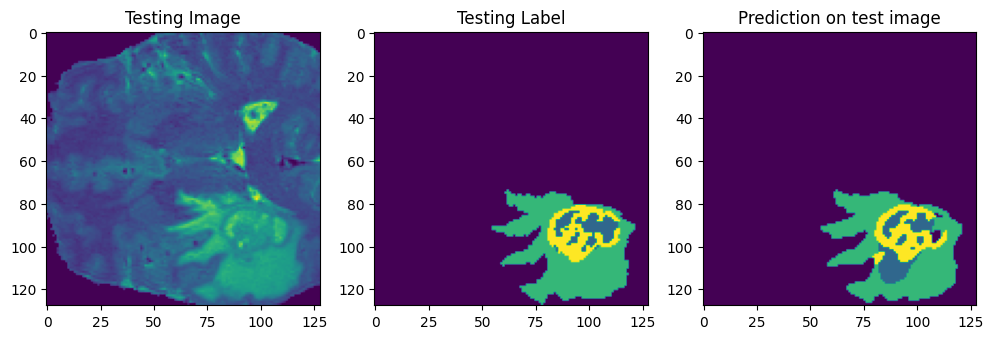

In [8]:
img_num = 82

test_img = np.load("BraTS2020_TrainingData/input_data_128/test/images/image_"+str(img_num)+".npy")

test_mask = np.load("BraTS2020_TrainingData/input_data_128/test/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model_1.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


print(test_prediction_argmax.shape)
print(test_mask_argmax.shape)
print(np.unique(test_prediction_argmax))


#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,2])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

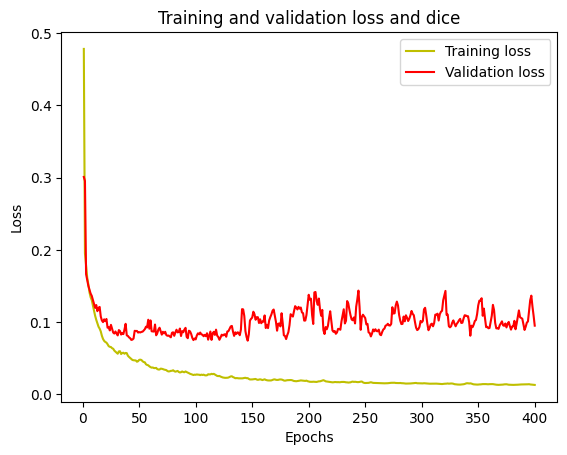

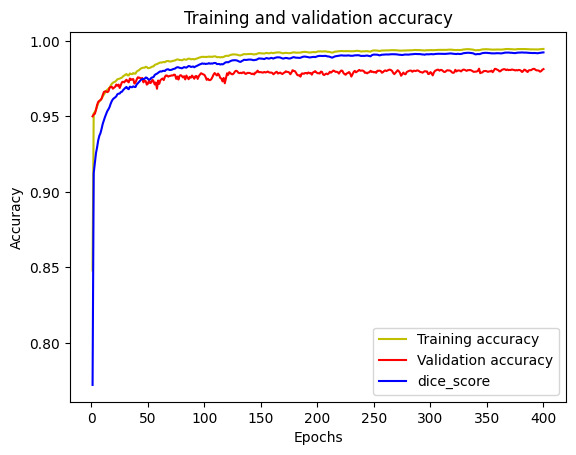

In [9]:
#plot the training and validation IoU and loss at each epoch

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
dice_score = history_1.history['dice_coefficient']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.plot(epochs, dice_score, 'g', label='dice_score')
plt.title('Training and validation loss and dice')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.plot(epochs, dice_score, 'b', label='dice_score')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
#Verify IoU on a batch of images from the test dataset
#Using built in keras function for IoU
#Only works on TF > 2.0
from keras.metrics import MeanIoU

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = model_1.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.68462294


In [11]:
model_1.compile(optimizer = optim_1, loss='categorical_crossentropy', metrics=metrics_1)

print("Evaluate on test data")
accuracy, iou_score, iou_score, dice_coefficient,dice_loss, dice_loss_plus_1focal_loss = model_1.evaluate(test_img_datagen, batch_size=16, 
                                                                                                          verbose =1, steps=test_steps_per_epoch)
print("Test Loss: ", accuracy)
print("Accuracy: ", iou_score)
print("dice score: ", iou_score)
print("dice_coefficient ", dice_coefficient)
print("dice_loss ", dice_loss)
print("dice_loss_plus_1focal_loss ", dice_loss_plus_1focal_loss)


Evaluate on test data
4/4 [==============================] - 8s 2s/step - loss: 0.1083 - accuracy: 0.9785 - iou_score: 0.6087 - dice_coefficient: 0.9762 - dice_loss: 0.0238 - dice_loss_plus_1focal_loss: 0.8290
Test Loss:  0.10828550904989243
Accuracy:  0.6086890697479248
dice score:  0.6086890697479248
dice_coefficient  0.976249098777771
dice_loss  0.02375093102455139
dice_loss_plus_1focal_loss  0.8290437459945679


In [12]:
# accuracy,iou_score,iou_score,dice_coefficient,dice_loss,dice_loss_plus_1focal_loss = my_model.evaluate(val_img_datagen, steps=val_steps_per_epoch)

# print("Test Loss: ", test_loss)
# print("Accuracy: ", test_dice)
# print("dice score: ", test_dice_loss)

# new edits (model number 2)

In [6]:
# dice loss as defined above for 4 classes
def dice_coef_2(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
            
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss

# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic_2(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,:,1] * y_pred[:,:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema_2(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,:,2] * y_pred[:,:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing_2(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,:,3] * y_pred[:,:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)


# Computing Precision 
def precision_2(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity_2(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity_2(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [7]:
model_2 = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_19 (Conv3D)             (None, 128, 128, 12  1312        ['input_2[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 12  0           ['conv3d_19[0][0]']              
                                8, 16)                                                      

In [8]:
model_2.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), 
                           dice_coef_2, precision_2, sensitivity_2, specificity_2, dice_coef_necrotic_2, dice_coef_edema_2 ,dice_coef_enhancing_2])

In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# filepath="3D-UNet-2018-weights-improvement-{epoch:02d}-{val_accuracy:.3f}.hdf5" 

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# early_stop = EarlyStopping(monitor='val_loss',min_delta=0.001, patience=15, verbose=1, restore_best_weights=True)

# csv_logger = CSVLogger('training_2018_3D_UNet.log')

start_time = time.time()

history_2 =  model_2.fit(train_img_datagen,
                    epochs=400,
                    verbose = 1,
                    steps_per_epoch=steps_per_epoch,
                    # callbacks= [csv_logger, early_stop],
                    validation_data = val_img_datagen,
                    validation_steps=val_steps_per_epoch,
                    )

end_time = time.time()
runtime_seconds = end_time - start_time

# Convert runtime to hours, minutes, and seconds
hours = int(runtime_seconds // 3600)
minutes = int((runtime_seconds % 3600) // 60)
seconds = int(runtime_seconds % 60)

print(f"Runtime: {hours} hours, {minutes} minutes, {seconds} seconds")

Epoch 1/400
120/120 [==============================] - 137s 970ms/step - loss: 0.3878 - accuracy: 0.9236 - mean_io_u: 0.4014 - dice_coef_2: 0.2445 - precision_2: 0.9349 - sensitivity_2: 0.8599 - specificity_2: 0.9833 - dice_coef_necrotic_2: 0.0792 - dice_coef_edema_2: 0.0770 - dice_coef_enhancing_2: 0.0413 - val_loss: 0.3779 - val_accuracy: 0.9501 - val_mean_io_u: 0.3757 - val_dice_coef_2: 0.2540 - val_precision_2: 0.9729 - val_sensitivity_2: 0.7965 - val_specificity_2: 0.9926 - val_dice_coef_necrotic_2: 0.1793 - val_dice_coef_edema_2: 0.2654 - val_dice_coef_enhancing_2: 0.1542
Epoch 2/400
120/120 [==============================] - 114s 955ms/step - loss: 0.2045 - accuracy: 0.9521 - mean_io_u: 0.4264 - dice_coef_2: 0.2905 - precision_2: 0.9583 - sensitivity_2: 0.9440 - specificity_2: 0.9863 - dice_coef_necrotic_2: 0.1114 - dice_coef_edema_2: 0.1541 - dice_coef_enhancing_2: 0.0533 - val_loss: 0.4182 - val_accuracy: 0.9501 - val_mean_io_u: 0.3750 - val_dice_coef_2: 0.2537 - val_precision

# test data

(128, 128, 128)
(128, 128, 128)
[0 1 2 3]


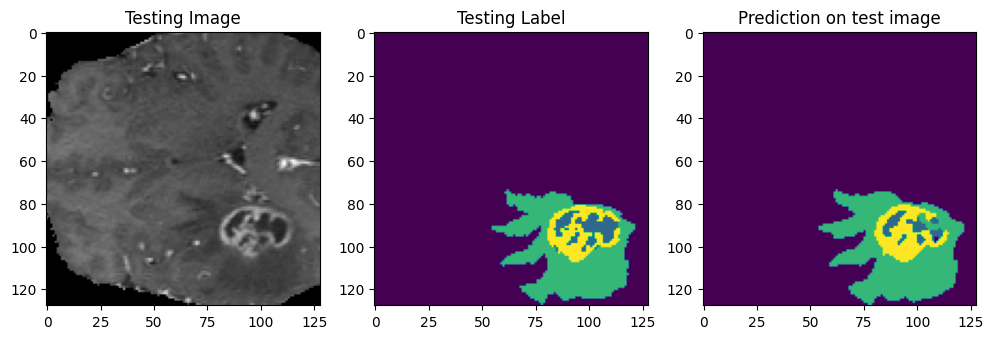

In [10]:
img_num = 82

test_img = np.load("BraTS2020_TrainingData/input_data_128/test/images/image_"+str(img_num)+".npy")

test_mask = np.load("BraTS2020_TrainingData/input_data_128/test/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model_2.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


print(test_prediction_argmax.shape)
print(test_mask_argmax.shape)
print(np.unique(test_prediction_argmax))


#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

# validation images

(128, 128, 128)
(128, 128, 128)
[0 1 2 3]


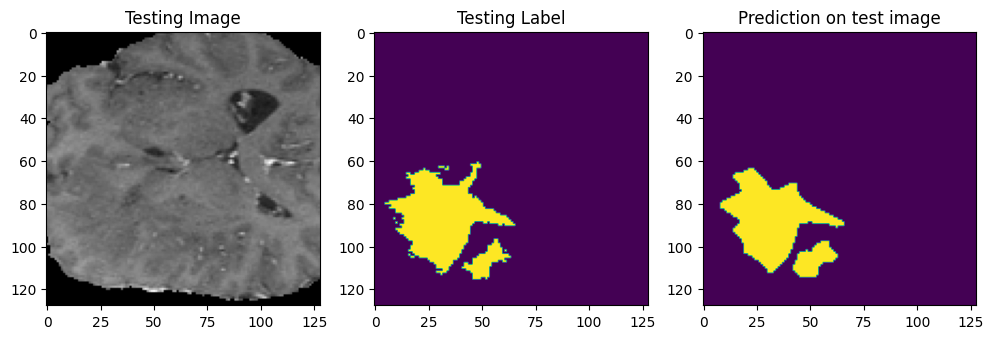

In [11]:
img_num = 5

test_img = np.load("BraTS2020_TrainingData/input_data_128/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("BraTS2020_TrainingData/input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model_2.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


print(test_prediction_argmax.shape)
print(test_mask_argmax.shape)
print(np.unique(test_prediction_argmax))


#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

In [12]:
model_2.save("brats_3d_model_2.hdf5")

In [13]:
history_2.history.keys()

dict_keys(['loss', 'accuracy', 'mean_io_u', 'dice_coef_2', 'precision_2', 'sensitivity_2', 'specificity_2', 'dice_coef_necrotic_2', 'dice_coef_edema_2', 'dice_coef_enhancing_2', 'val_loss', 'val_accuracy', 'val_mean_io_u', 'val_dice_coef_2', 'val_precision_2', 'val_sensitivity_2', 'val_specificity_2', 'val_dice_coef_necrotic_2', 'val_dice_coef_edema_2', 'val_dice_coef_enhancing_2'])

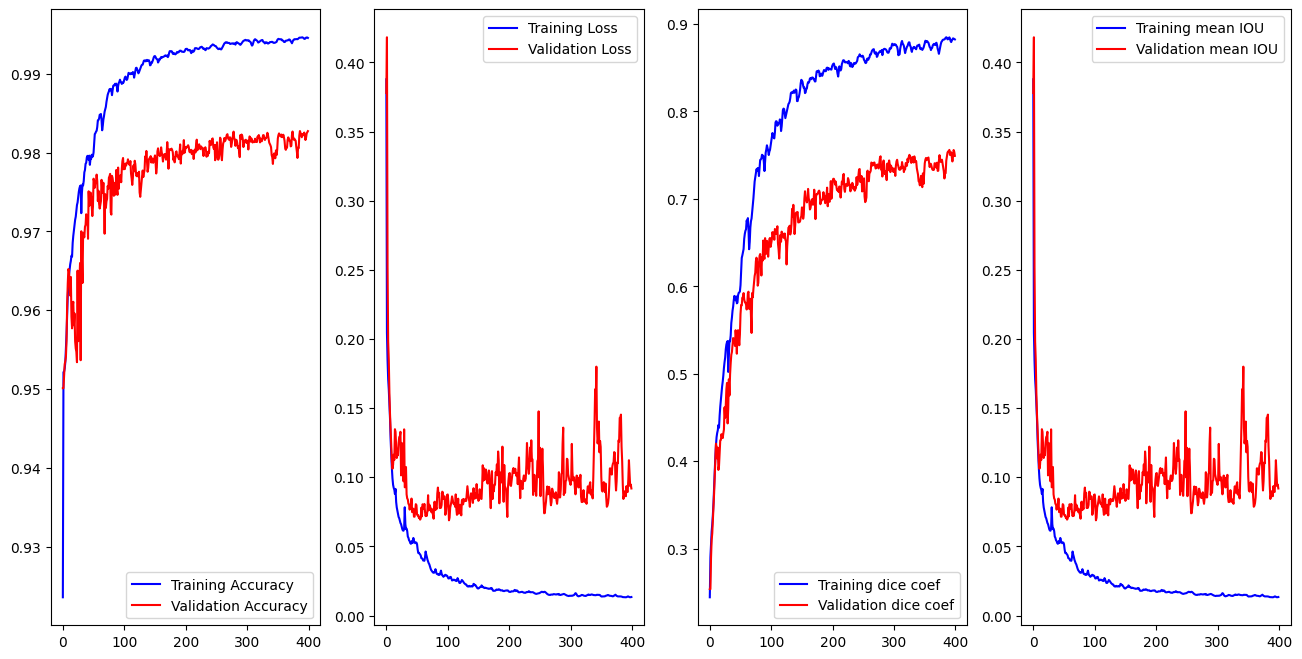

In [14]:

# hist=history
#  dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing
############### ########## ####### #######

hist=history_2.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef_2']
val_dice=hist['val_dice_coef_2']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['loss'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_loss'],'r',label='Validation mean IOU')
ax[3].legend()
plt.savefig('training_result_2018.png')
plt.show()

In [15]:
# csv_logger = CSVLogger('evaluation_2018_3D_UNet.log')
model_2.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                metrics = ['accuracy', dice_coef_2, precision_2, sensitivity_2, specificity_2, dice_coef_necrotic_2, dice_coef_edema_2, dice_coef_enhancing_2] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model_2.evaluate(test_img_datagen, batch_size=16, 
                        #    callbacks= [csv_logger],
                           verbose =1, steps=test_steps_per_epoch)
li = ['accuracy', 'dice_coef_2', 'precision_2', 'sensitivity_2', 'specificity_2', 'dice_coef_necrotic_2', 'dice_coef_edema_2', 'dice_coef_enhancing_2']
for i in range(len(li)):
   print(f"{li[i]} {results[i]}")

Evaluate on test data
4/4 [==============================] - 11s 1s/step - loss: 0.0963 - accuracy: 0.9817 - dice_coef_2: 0.7657 - precision_2: 0.9824 - sensitivity_2: 0.9813 - specificity_2: 0.9942 - dice_coef_necrotic_2: 0.6044 - dice_coef_edema_2: 1.0659 - dice_coef_enhancing_2: 0.8387
accuracy 0.09630531072616577
dice_coef_2 0.9817148447036743
precision_2 0.7657482624053955
sensitivity_2 0.9824370741844177
specificity_2 0.981288731098175
dice_coef_necrotic_2 0.9941526055335999
dice_coef_edema_2 0.6043910384178162
dice_coef_enhancing_2 1.0658812522888184


In [16]:
#Verify IoU on a batch of images from the test dataset
#Using built in keras function for IoU
#Only works on TF > 2.0
from keras.metrics import MeanIoU

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = model_2.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.7390858
